# Siamese CNN & vae

*Created by Holger Buech, Q1/2019*

**Description**   

Reimplemenation of an approach to Continuous Authentication described by [1]. It leverages a Siamese CNN to generate Deep Features, which are then used as input for an OCSVM authentication classifier.  

**Purpose**

- Verify results of [1]
- Test the approach with upfront global subject wise normalization (NAIVE_APPROACH)
- Change the normalization setting to be more realistic: Training data is normalized upfront again, but the Testing data is normalized using a single scaler fitted on training data only. (VALID_APPROACH)
- Identify parameters performing better in a valid setup than the parameters proposed by [1]. (ALTERNATIVE_APPROACH) 

**Data Sources**   

- [H-MOG Dataset](http://www.cs.wm.edu/~qyang/hmog.html)  
  (Downloaded beforehand using  [./src/data/make_dataset.py](./src/data/make_dataset.py), stored in [./data/external/hmog_dataset/](./data/external/hmog_dataset/) and converted to [./data/processed/hmog_dataset.hdf5](./data/processed/hmog_dataset.hdf5))

**References**   

- [1] Centeno, M. P. et al. (2018): Mobile Based Continuous Authentication Using Deep Features. Proceedings of the 2^nd International Workshop on Embedded and Mobile Deep Learning (EMDL), 2018, 19-24.

**Table of Contents**

**1 - [Preparations](#1)**   
1.1 - [Imports](#1.1)   
1.2 - [Configuration](#1.2)   
1.3 - [Experiment Parameters](#1.3)   
1.4 - [Select Approach](#1.4)   

**2 - [Initial Data Prepratation](#2)**   
2.1 - [Load Dataset](#2.1)   
2.2 - [Normalize Features (if global)](#2.2)   
2.3 - [Split Dataset for Valid/Test](#2.3)   
2.4 - [Normalize Features (if not global)](#2.4)   
2.5 - [Check Splits](#2.5)   
2.6 - [Reshape Features](#2.6)     

**3 - [Generate Scenario Pairs](#3)**    
3.1 - [Load cached Data](#3.1)  
3.2 - [Build positive/negative Pairs](#3.2)  
3.3 - [Inspect Pairs](#3.3)  
3.4 - [Cache Pairs](#3.4)  

**4 - [Siamese Network](#4)**  
4.1 - [Load cached Pairs](#4.1)   
4.2 - [Build Model](#4.2)   
4.3 - [Prepare Features](#4.3)   
4.4 - [Search optimal Epoch](#4.4)   
4.5 - [Check Distances](#4.5)   
4.6 - [Rebuild and train to optimal Epoch](#4.6)   
4.7 - [Cache Model](#4.7)   

**5 - [Visualize Deep Features](#5)**   
5.1 - [Load cached Data](#5.1)  
5.2 - [Extract CNN from Siamese Model](#5.2)  
5.3 - [Test Generation of Deep Features](#5.3)  
5.4 - [Visualize in 2D using PCA](#5.4)  

**6 - [OCSVM](#6)**  
6.1 - [Load cached Data](#6.1)  
6.2 - [Load trained Siamese Model](#6.2)  
6.3 - [Search for Parameters](#6.3)  
6.4 - [Inspect Search Results](#6.4) 

**7 - [Testing](#7)**  
7.1 - [Load cached Data](#7.1)  
7.2 - [Evaluate Auth Performance](#7.2)  
7.3 - [Evaluate increasing Training Set Size (Training Delay)](#7.3)  
7.4 - [Evaluate increasing Test Set Sizes (Detection Delay)](#7.4)  

**8 - [Report Results](#8)**  

## 1. Preparations <a id='1'>&nbsp;</a> 

### 1.1 Imports <a id='1.1'>&nbsp;</a> 
**Note:** The custom `DatasetLoader` is a helper class for easier loading and subsetting data from the datasets.

In [1]:
# Standard
from pathlib import Path
import os
import sys
import warnings
import random
import dataclasses
import math
import multiprocessing as mp

# Extra
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.decomposition import PCA
import statsmodels.stats.api as sms
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import (
    Dense,
    Input,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Lambda,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling1D,
    Activation
)
from keras.utils import plot_model
from keras.optimizers import Adam, SGD,RMSprop
from keras.models import load_model
from keras.callbacks import Callback
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Custom
module_path = os.path.abspath(os.path.join(".."))  # supposed to be parent folder
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utility.dataset_loader_hdf5 import DatasetLoader

# Global utitlity functions are loaded from separate notebook:
%run utils.ipynb

Using TensorFlow backend.


### 1.2 Configuration <a id='1.2'>&nbsp;</a>

In [2]:
# Configure Data Loading & Seed
SEED = 712  # Used for every random function
HMOG_HDF5 = Path.cwd().parent / "data" / "processed" / "hmog_dataset.hdf5"
EXCLUDE_COLS = ["sys_time"]
CORES = mp.cpu_count()

# For plots and CSVs
OUTPUT_PATH = Path.cwd() / "output" / "chapter-6-1-4-siamese-cnn"  # Cached data & csvs
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
REPORT_PATH = Path.cwd().parent / "reports" / "figures" # Figures for thesis
REPORT_PATH.mkdir(parents=True, exist_ok=True)

# Improve performance of Tensorflow (this improved speed _a_lot_ on my machine!!!)
K.tf.set_random_seed(SEED)
conf = K.tf.ConfigProto(
    device_count={"CPU": CORES},
    allow_soft_placement=True,
    intra_op_parallelism_threads=CORES,
    inter_op_parallelism_threads=CORES,
)
K.set_session(K.tf.Session(config=conf))

# Plotting
%matplotlib inline
utils_set_output_style()

# Silence various deprecation warnings...
tf.logging.set_verbosity(tf.logging.ERROR)
np.warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

In [3]:
# Workaround to remove ugly spacing between tqdm progress bars:
HTML("<style>.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty{padding: 0;border: 0;} div.output_subarea{padding:0;}</style>")

### 1.3 Experiment Parameters <a id='1.3'>&nbsp;</a> 
Selection of parameters set that had been tested in this notebook. Select one of them to reproduce results.

In [4]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Experiments Parameter set. Used as identifier for charts etc.

    # Data / Splitting:
    frequency: int
    feature_cols: list  # Columns used as features
    max_subjects: int
    exclude_subjects: list  # Don't load data from those users
    n_valid_train_subjects: int
    n_valid_test_subjects: int
    n_test_train_subjects: int
    n_test_test_subjects: int
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    task_types: list  # Limit scenarios to [1, 3, 5] for sitting or [2, 4, 6] for walking, or don't limit (None)

    # Reshaping
    window_size: int  # After resampling
    step_width: int  # After resampling

    # Normalization
    scaler: str  # {"std", "robust", "minmax"}
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # scale training and testing sets at once (True), or fit scaler on training only (False)

    # Siamese Network
    max_pairs_per_session: int  # Max. number of pairs per session
    margin: float  # Contrastive Loss Margin
    model_variant: str  # {"1d", "2d"} Type of architecture
    filters: list  # List of length 4, containing number of filters for conv layers
    epochs_best: int  # Train epochs to for final model
    epochs_max: int
    batch_size: int
    optimizer: str  # Optimizer to use for Siamese Network
    optimizer_lr: float  # Learning Rate
    optimizer_decay: float

    # OCSVM
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model

    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        # Number of samples per _session_ used for training:
        self.samples_per_subject_train = math.ceil(
            (self.seconds_per_subject_train * 100)
            / (100 / self.frequency)
            / self.window_size
        )

        # Number of samples per _session_ used for testing:
        self.samples_per_subject_test = math.ceil(
            (self.seconds_per_subject_test * 100)
            / (100 / self.frequency)
            / self.window_size
        )


# INSTANCES
# ===========================================================

# NAIVE_MINMAX (2D Filters)
# -----------------------------------------------------------
NAIVE_MINMAX_2D = ExperimentParameters(
    name="NAIVE-MINMAX-2D",
    # Data / Splitting
    frequency=25,
    feature_cols=[
        "acc_x",
        "acc_y",
        "acc_z",
        "gyr_x",
        "gyr_y",
        "gyr_z",
        "mag_x",
        "mag_y",
        "mag_z",
    ],
    max_subjects=90,
    exclude_subjects=[
        "733162",  # No 24 sessions
        "526319",  # ^
        "796581",  # ^
        "539502",  # Least amount of sensor values
        "219303",  # ^
        "737973",  # ^
        "986737",  # ^
        "256487",  # Most amount of sensor values
        "389015",  # ^
        "856401",  # ^
    ],
    n_valid_train_subjects=40,
    n_valid_test_subjects=10,
    n_test_train_subjects=10,
    n_test_test_subjects=30,
    seconds_per_subject_train=67.5,
    seconds_per_subject_test=67.5,
    task_types=None,
    # Reshaping
    window_size=25,  # 1 sec
    step_width=25,
    # Normalization
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    # Siamese Network
    model_variant="2d",
    filters=[32, 64, 128, 32],
    epochs_best=35,
    epochs_max=40,
    batch_size=200,
    optimizer="sgd",
    optimizer_lr=0.01,
    optimizer_decay=0,
    max_pairs_per_session=60,  # => 4min
    margin=0.2,
    # OCSVM
    ocsvm_nu=0.092,
    ocsvm_gamma=1.151,
)  # <END NAIVE_APPROACH>

# VALID_MINMAX (2D)
# -----------------------------------------------------------
VALID_MINMAX_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-MINMAX-2D",
    task_types=None,
    scaler_global=False,
    epochs_max=40,
    ocsvm_nu=0.110,
    ocsvm_gamma=59.636,
)

# NAIVE_ROBUST (2D)
# -----------------------------------------------------------
NAIVE_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="NAIVE-ROBUST-2D",
    scaler="robust",
    optimizer="sgd",
    optimizer_lr=0.05, # Decreased, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    epochs_best=5,
    ocsvm_nu=0.214,
    ocsvm_gamma=2.354,
)

# VALID_ROBUST (2D)
# -----------------------------------------------------------
VALID_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-2D",
    scaler="robust",
    scaler_global=False,
    epochs_best=6,
    epochs_max=20,
    optimizer="sgd",
    optimizer_lr=0.05,  # Decrease LR, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    ocsvm_nu=0.190,
    ocsvm_gamma=0.069,
)

# VALID_ROBUST (1D)
# -----------------------------------------------------------
VALID_ROBUST_1D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-1D",
    scaler="robust",
    scaler_global=False,
    model_variant="1d", 
    filters=[32, 64, 128, 64],    
    epochs_best=9,
    epochs_max=20,
    ocsvm_nu=0.156,
    ocsvm_gamma=33.932,
)

# FCN_ROBUST (1D)
# -----------------------------------------------------------
VALID_FCN_ROBUST = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[2, 4, 6],
    feature_cols=["acc_x", "acc_y", "acc_z"], 
    frequency=25,
    window_size=25*5,
    step_width=25*5,
    scaler="robust",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.001,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.165,
    ocsvm_gamma=8.296,
)

### 1.4 Select Approach <a id='1.4'>&nbsp;</a> 
Select the parameters to use for current notebook execution here!

In [5]:
P = VALID_FCN_ROBUST

**Overview of current Experiment Parameters:**

In [6]:
utils_ppp(P)

,Value
batch_size,300
epochs_best,40
epochs_max,80
exclude_subjects,"[733162, 526319, 796581, 539502, 219303, 73797..."
feature_cols,"[acc_x, acc_y, acc_z]"
filters,"[32, 64, 32]"
frequency,25
margin,1
max_pairs_per_session,600
max_subjects,90


## 2. Initial Data Preparation <a id='2'>&nbsp;</a> 

### 2.1 Load Dataset <a id='2.1'>&nbsp;</a> 

In [7]:
hmog = DatasetLoader(
    hdf5_file=HMOG_HDF5,
    table_name=P.table_name,
    max_subjects=P.max_subjects,
    task_types=P.task_types,
    exclude_subjects=P.exclude_subjects,
    exclude_cols=EXCLUDE_COLS,
    seed=SEED,
)
hmog.data_summary()

,DataFrame,Memory (MB),Rows,Columns,Subjects,Sessions
0,all,1437.64,14494937,12,90,1080
1,index,0.08,2160,4,90,2160


### 2.2 Normalize Features (if global) <a id='2.2'>&nbsp;</a> 
Used here for naive approach (before splitting into test and training sets). Otherwise it's used during generate_pairs() and respects train vs. test borders.

In [8]:
if P.scaler_global:
    print("Normalize all data before splitting into train and test sets...")
    hmog.all, scalers = utils_custom_scale(
        hmog.all,
        scale_cols=P.feature_cols,        
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,
    )
else:
    print("Skipped, normalize after splitting.")

Skipped, normalize after splitting.


### 2.3 Split Dataset for Valid/Test <a id='2.3'>&nbsp;</a> 
In two splits: one used during hyperparameter optimization, and one used during testing.

The split is done along the subjects: All sessions of a single subject will either be in the validation split or in the testing split, never in both.

In [9]:
hmog.split_train_valid_train_test(
    n_valid_train=P.n_valid_train_subjects,
    n_valid_test=P.n_valid_test_subjects,
    n_test_train=P.n_test_train_subjects,
    n_test_test=P.n_test_test_subjects,
)
hmog.data_summary()

,DataFrame,Memory (MB),Rows,Columns,Subjects,Sessions
0,index,0.08,2160,4,90,2160
1,valid_train,652.12,6575003,12,40,480
2,valid_test,148.80,1500294,12,10,120
3,test_train,160.42,1617398,12,10,120
4,test_test,476.30,4802242,12,30,360


### 2.4 Normalize features (if not global) <a id='2.4'>&nbsp;</a> 

Scaling Data for Siamese Network only...
Training Data:
Before Scaling:


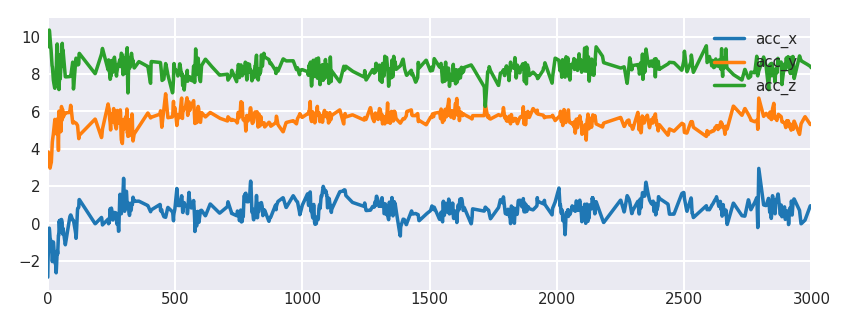

After Scaling:


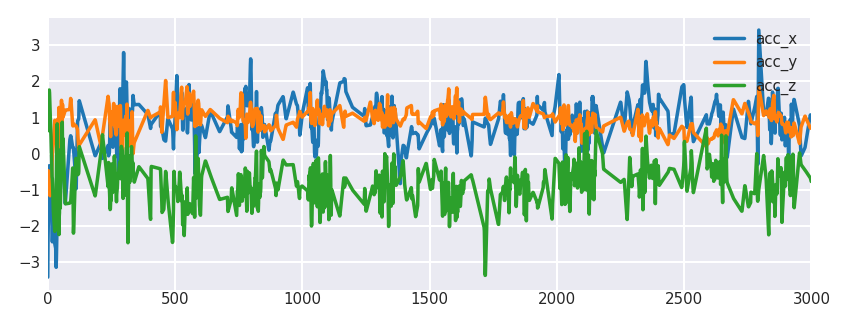

Validation Data:
Before Scaling:


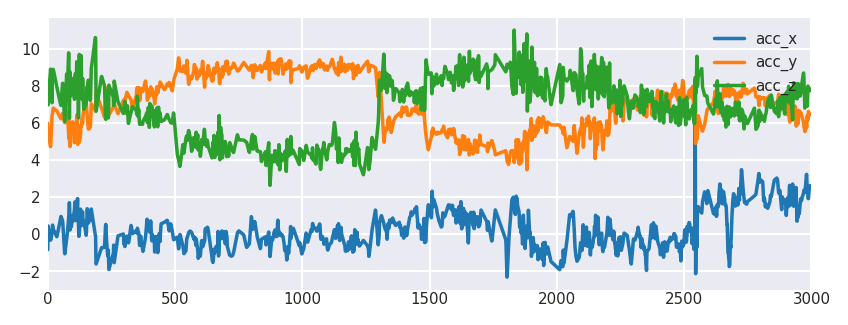

After Scaling:


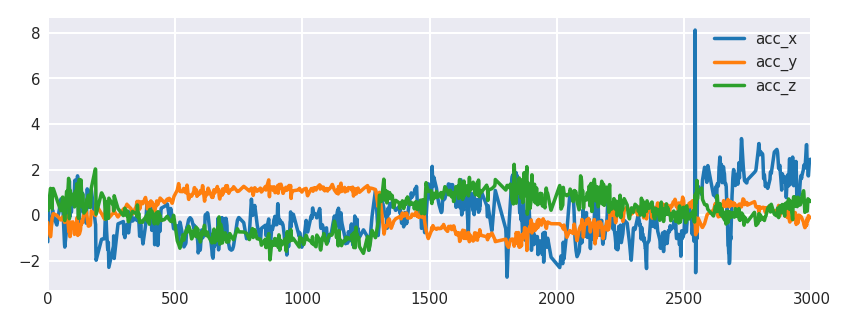

In [10]:
if not P.scaler_global:
    print("Scaling Data for Siamese Network only...")
    print("Training Data:")
    hmog.valid_train, _ = utils_custom_scale(
        hmog.valid_train,
        scale_cols=P.feature_cols,
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,        
    )
    print("Validation Data:")
    hmog.valid_test, _ = utils_custom_scale(
        hmog.valid_test,
        scale_cols=P.feature_cols,        
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,        
    )
else:
    print("Skipped, already normalized.")    

### 2.5 Check Splits <a id='2.5'>&nbsp;</a> 

In [11]:
utils_split_report(hmog.valid_train)

Unique subjects: 40
Unique sessions: 480

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,-3.412751,-0.859470,0.802647,-0.601588,0.193339,0.149184,-4.416808,-18.677058,4.042481,865501,865501_session_12,6
1,-2.399551,-0.473180,1.313625,-0.300374,0.114175,0.497483,-4.240847,-17.911847,3.674885,865501,865501_session_12,6
2,-2.019445,-0.475216,1.095866,-0.160162,0.136490,0.434803,-4.053154,-17.692154,3.456116,865501,865501_session_12,6
3,-1.682592,-0.506074,0.834975,0.111769,0.138812,0.265335,-3.856505,-17.486192,3.230707,865501,865501_session_12,6
4,-1.332844,-0.539390,0.632733,0.102549,0.301903,0.182352,-3.562962,-17.466766,2.962154,865501,865501_session_12,6




Sessions' Task Types per subject:


subject,100669,171538,218719,220962,240168,248252,326223,352716,366286,405035,431312,472761,525584,540641,553321,554303,588087,621276,622852,663153,675397,693572,717868,733568,745224,751131,763813,771782,803262,856302,862649,865501,865881,876011,892687,897652,913228,962159,973891,980953
2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
6,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [12]:
utils_split_report(hmog.valid_test)

Unique subjects: 10
Unique sessions: 120

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,-1.168579,-0.328185,0.229415,-0.068970,-0.272866,0.453358,3.777375,6.74075,-11.045000,808022,808022_session_14,2
1,0.177322,-0.574819,0.207275,-0.193158,-0.035115,0.200259,3.496544,6.55200,-11.031676,808022,808022_session_14,2
2,0.096880,-0.611919,0.303763,-0.172092,0.001737,0.063053,3.292662,6.55200,-10.996147,808022,808022_session_14,2
3,0.016438,-0.649019,0.400250,-0.149948,0.041291,-0.003073,3.088779,6.55200,-10.960618,808022,808022_session_14,2
4,-0.064005,-0.686119,0.496738,-0.127805,0.080844,-0.069199,2.884897,6.55200,-10.925088,808022,808022_session_14,2




Sessions' Task Types per subject:


subject,277905,396697,489146,578526,594887,776328,777078,799296,808022,923862
2,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4
6,4,4,4,4,4,4,4,4,4,4


In [13]:
utils_split_report(hmog.test_train)

Unique subjects: 10
Unique sessions: 120

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,0.688068,4.688514,9.120988,-0.078252,0.450208,0.695653,6.23400,-14.868125,-34.456750,785873,785873_session_10,4
1,0.542114,4.478009,9.112148,-0.152533,0.455095,0.571525,6.23400,-14.988458,-34.565417,785873,785873_session_10,4
2,0.396160,4.267503,9.103308,-0.226814,0.459982,0.447397,6.23400,-15.108792,-34.674083,785873,785873_session_10,4
3,0.250206,4.056998,9.094467,-0.301096,0.464868,0.323270,6.36225,-15.248875,-34.742000,785873,785873_session_10,4
4,0.104251,3.846492,9.085627,-0.275299,0.499977,0.278209,6.70425,-15.421875,-34.742000,785873,785873_session_10,4




Sessions' Task Types per subject:


subject,186676,201848,264325,368258,698266,710707,785873,815316,827212,879155
2,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4
6,4,4,4,4,4,4,4,4,4,4


In [14]:
utils_split_report(hmog.test_test)

Unique subjects: 30
Unique sessions: 360

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,-0.204404,5.035904,8.418314,-0.077475,-0.044569,-0.019363,-27.751167,15.160111,-2.113555,579284,579284_session_1,4
1,-0.354591,5.342461,8.230168,0.021356,0.016582,-0.022128,-28.052944,14.979074,-2.555037,579284,579284_session_1,4
2,-0.351473,5.612957,8.443053,0.120188,0.077733,-0.024893,-28.354722,14.798037,-2.996518,579284,579284_session_1,4
3,-0.104447,5.637447,8.342297,0.219019,0.138883,-0.027658,-28.656500,14.617000,-3.437999,579284,579284_session_1,4
4,0.059905,5.838211,8.536127,0.317851,0.200034,-0.030423,-28.958277,14.435963,-3.879481,579284,579284_session_1,4




Sessions' Task Types per subject:


subject,151985,180679,207696,257279,261313,278135,336172,342329,395129,398248,501973,527796,538363,556357,561993,579284,657486,720193,785899,841866,863985,872895,893198,893255,918136,937904,966655,984799,990622,998757
2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
6,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


### 2.6 Reshape Features  <a id='2.6'>&nbsp;</a> 

**Reshape & cache Set for Training Siamese Network:**

In [15]:
df_siamese_train = utils_reshape_features(
    hmog.valid_train,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

# Clean memory
del hmog.train
%reset_selective -f hmog.train

print("Validation data after reshaping:")
display(df_siamese_train.head())

# Store iterim data
df_siamese_train.to_msgpack(OUTPUT_PATH / "df_siamese_train.msg")

# Clean memory
%reset_selective -f df_siamese_train

Validation data after reshaping:


,X,subject,session,task_type
0,"[[1.126538556309365, -5.676733181236054, 3.232...",100669,100669_session_12,6
1,"[[0.35454249979518676, -1.2795481927044285, 0....",100669,100669_session_12,6
2,"[[0.5150551243002253, -1.6982955451723616, 0.6...",100669,100669_session_12,6
3,"[[-0.9393853286507788, -2.2431333573807604, 1....",100669,100669_session_12,6
4,"[[0.00042849556207466284, -2.142130982688511, ...",100669,100669_session_12,6


**Reshape & cache Set for Validating Siamese Network:** (also used to optimize OCSVM)

In [16]:
df_siamese_valid = utils_reshape_features(
    hmog.valid_test,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

del hmog.valid
%reset_selective -f hmog.valid

print("Testing data after reshaping:")
display(df_siamese_valid.head())

# Store iterim data
df_siamese_valid.to_msgpack(OUTPUT_PATH / "df_siamese_valid.msg")

# Clean memory
%reset_selective -f df_siamese_valid

Testing data after reshaping:


,X,subject,session,task_type
0,"[[0.2755904486556705, 0.9555282896636191, 1.54...",277905,277905_session_11,6
1,"[[-0.2562074210816752, 0.709772021775287, -0.3...",277905,277905_session_11,6
2,"[[0.22530963427241976, -0.5863897734333892, 0....",277905,277905_session_11,6
3,"[[1.0569904280299165, -0.05788757446838152, 0....",277905,277905_session_11,6
4,"[[-0.4410834280235254, 0.1232692931937304, -0....",277905,277905_session_11,6


**Reshape & cache Set for Training/Validation OCSVM:**

In [17]:
df_ocsvm_train_valid = utils_reshape_features(
    hmog.test_train,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

del hmog.test_train
%reset_selective -f hmog.test_train

print("Testing data after reshaping:")
display(df_ocsvm_train_valid.head())

# Store iterim data
df_ocsvm_train_valid.to_msgpack(OUTPUT_PATH / "df_ocsvm_train_valid.msg")

# Clean memory
%reset_selective -f df_ocsvm_train_valid

Testing data after reshaping:


,X,subject,session,task_type
0,"[[-8.607810569636623, 0.9955167241816556, -1.9...",186676,186676_session_1,4
1,"[[-0.3209477333333335, 3.128859958333334, 9.44...",186676,186676_session_1,4
2,"[[-2.057314, 4.621461133928572, 7.006203626785...",186676,186676_session_1,4
3,"[[0.534176783756579, 6.0081232518346415, 8.295...",186676,186676_session_1,4
4,"[[-1.53348510239776, 5.71207867121504, 8.14309...",186676,186676_session_1,4


**Reshape & cache Set for Training/Testing OCSVM:**

In [18]:
df_ocsvm_train_test = utils_reshape_features(
    hmog.test_test,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

del hmog.test_test
%reset_selective -f hmog.test_test

print("Testing data after reshaping:")
display(df_ocsvm_train_test.head())

# Store iterim data
df_ocsvm_train_test.to_msgpack(OUTPUT_PATH / "df_ocsvm_train_test.msg")

# Clean memory
%reset_selective -f df_ocsvm_train_test
%reset_selective -f df_

Testing data after reshaping:


,X,subject,session,task_type
0,"[[-0.3765385456074766, 3.1107421714953274, 7.7...",151985,151985_session_10,6
1,"[[0.09549826478869189, 3.9700954602219136, 7.7...",151985,151985_session_10,6
2,"[[0.20883461625482397, 3.2271731154792, 8.6506...",151985,151985_session_10,6
3,"[[0.0038022012564349096, 3.0280049158538764, 9...",151985,151985_session_10,6
4,"[[-2.4728418720348535, 3.5376784001577266, 7.4...",151985,151985_session_10,6


## 3. Generate Scenario Pairs <a id='3'>&nbsp;</a> 

### 3.1 Load cached Data <a id='3.1'>&nbsp;</a> 

In [19]:
df_siamese_train = pd.read_msgpack(OUTPUT_PATH / "df_siamese_train.msg")
df_siamese_valid = pd.read_msgpack(OUTPUT_PATH / "df_siamese_valid.msg")

### 3.2 Build positive/negative Pairs  <a id='3.2'>&nbsp;</a> 

In [20]:
def build_pairs(df):
    # Limit samples per subject to sample of shortest session
    df = df.groupby("session", group_keys=False).apply(
        lambda x: x.sample(min(len(x), P.max_pairs_per_session), random_state=SEED)
    )
    df_pairs = None

    # Split samples subject wise 50:50
    # ---------------
    df_positives = None
    df_negatives = None

    for subject in df["subject"].unique():
        # Shuffle
        df_subj = df[df["subject"] == subject].sample(frac=1, random_state=SEED)

        # Make rows even
        if len(df_subj) % 2 != 0:
            df_subj = df_subj.iloc[:-1]

        half = len(df_subj) // 2

        df_positives = pd.concat([df_positives, df_subj.iloc[:half]])
        df_negatives = pd.concat([df_negatives, df_subj.iloc[half:]])

    # Positive Pairs
    # ---------------
    df_positive_left = None
    df_positive_right = None

    for subject in df_positives["subject"].unique():
        df_subj = df[df["subject"] == subject]
        # Make rows even
        if len(df_subj) % 2 != 0:
            df_subj = df_subj.iloc[:-1]

        # Split in half
        half = len(df_subj) // 2
        df_positive_left = pd.concat([df_positive_left, df_subj.iloc[:half]])
        df_positive_right = pd.concat([df_positive_right, df_subj.iloc[half:]])

    df_positive_left = df_positive_left.reset_index(drop=True)
    df_positive_right = df_positive_right.reset_index(drop=True)
    df_positive_left.columns = ["left_" + c for c in df_positive_left.columns]
    df_positive_right.columns = ["right_" + c for c in df_positive_right.columns]

    df_positives = pd.concat(
        [df_positive_left, df_positive_right],
        axis=1,
        sort=False,
        join_axes=[df_positive_left.index],
    )

    # Negative Pairs
    # ---------------
    # Make rows even
    if len(df_negatives) % 2 != 0:
        df_negatives = df_negatives.iloc[:-1]

    # Split in half
    half = len(df_negatives) // 2
    df_negative_left = df_negatives.iloc[half:].reset_index(drop=True)
    df_negative_right = df_negatives.iloc[:half].reset_index(drop=True)

    # Name columns
    df_negative_left.columns = ["left_" + c for c in df_negative_left.columns]
    df_negative_right.columns = ["right_" + c for c in df_negative_right.columns]

    # Combine
    df_negatives = pd.concat(
        [df_negative_left, df_negative_right],
        axis=1,
        sort=False,
        join_axes=[df_negative_left.index],
    )

    # Combine both Pairs
    # ---------------
    # Balance pairs
    min_len = min(len(df_positives), len(df_negatives))
    df_positives = df_positives.sample(n=min_len, random_state=SEED)
    df_negatives = df_negatives.sample(n=min_len, random_state=SEED)

    # Combine
    df_pairs = pd.concat([df_positives, df_negatives], sort=False)

    # Shuffle
    df_pairs = df_pairs.sample(frac=1, random_state=SEED).reset_index(drop=True)

    # Set Label
    df_pairs["label"] = np.where(
        df_pairs["left_subject"] == df_pairs["right_subject"], 1, 0
    )

    return df_pairs

In [21]:
# Reduce observations/samples per
print("Sample per session before reduction:\n ")
display(df_siamese_train["session"].value_counts().head(3))
display(df_siamese_valid["session"].value_counts().head(3))

df_siamese_train = df_siamese_train.groupby("session", group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), P.samples_per_subject_train), random_state=SEED)
)

df_siamese_valid = df_siamese_valid.groupby("session", group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), P.samples_per_subject_test), random_state=SEED)
)

print("\n\nSample per session after reduction:\n")
display(df_siamese_train["session"].value_counts().head(3))
display(df_siamese_valid["session"].value_counts().head(3))

Sample per session before reduction:
 


771782_session_5    449
733568_session_2    417
876011_session_4    339
Name: session, dtype: int64

396697_session_1    330
489146_session_4    232
489146_session_5    196
Name: session, dtype: int64



Sample per session after reduction:



763813_session_3     120
621276_session_9     120
326223_session_17    120
Name: session, dtype: int64

923862_session_17    120
594887_session_3     120
277905_session_3     120
Name: session, dtype: int64

In [22]:
df_siamese_train_pairs = build_pairs(df_siamese_train)
df_siamese_valid_pairs = build_pairs(df_siamese_valid)

### 3.3 Inspect Pairs <a id='3.3'>&nbsp;</a> 

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23202 entries, 0 to 23201
Data columns (total 9 columns):
left_X             23202 non-null object
left_subject       23202 non-null object
left_session       23202 non-null object
left_task_type     23202 non-null int64
right_X            23202 non-null object
right_subject      23202 non-null object
right_session      23202 non-null object
right_task_type    23202 non-null int64
label              23202 non-null int64
dtypes: int64(3), object(6)
memory usage: 1.6+ MB


None



Head:


,left_X,left_subject,left_session,left_task_type,right_X,right_subject,right_session,right_task_type,label
0,"((-0.6297935210090034, 0.4951728934596526, -0....",763813,763813_session_3,4,"((0.28326749900289105, 2.0060215193377346, -2....",248252,248252_session_15,4,0
1,"((0.5104422682179994, 0.6122515500276577, -0.5...",862649,862649_session_11,6,"((1.2646933163106933, 0.33840824373077677, 0.2...",862649,862649_session_20,2,1
2,"((-1.0483160558913844, 0.29523283522839033, -0...",248252,248252_session_1,6,"((-0.5668663595716247, -0.448976591970793, 0.0...",248252,248252_session_21,2,1
3,"((-0.3345441865487368, -0.7110693097661309, 0....",751131,751131_session_2,6,"((1.0921928655009012, 0.25441181749408487, -0....",240168,240168_session_13,4,0
4,"((0.7168224084245651, 0.9495752606997864, -0.8...",865501,865501_session_12,6,"((-0.37900006110641143, -0.30702400001101776, ...",865501,865501_session_22,4,1




Any NaN values?


left_X             0
left_subject       0
left_session       0
left_task_type     0
right_X            0
right_subject      0
right_session      0
right_task_type    0
label              0
dtype: int64




Distribution of Samples per Subjects in training Data


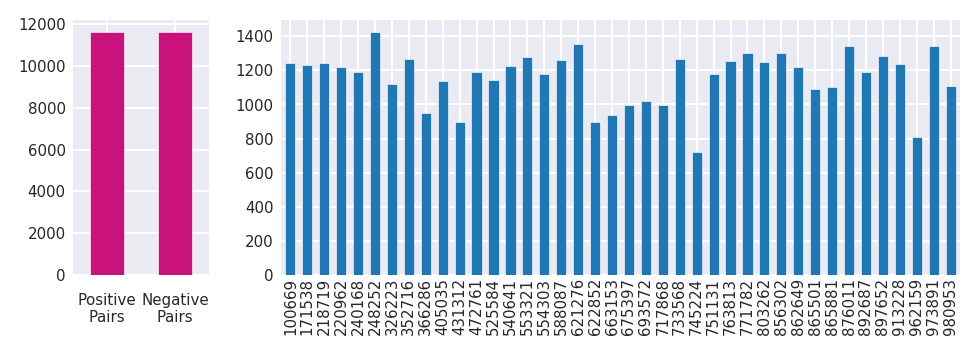

In [23]:
print("DataFrame Info:")
display(df_siamese_train_pairs.info())

print("\n\nHead:")
display(df_siamese_train_pairs.head(5))

print("\n\nAny NaN values?")
display(df_siamese_train_pairs.isnull().sum(axis = 0))

df_left_sub = df_siamese_train_pairs.groupby("left_subject")["left_subject"].count()
df_right_sub = df_siamese_train_pairs.groupby("right_subject")["right_subject"].count()
df_temp = pd.concat([df_left_sub, df_right_sub])

print("\n\n\nDistribution of Samples per Subjects in training Data")

fig, axes = plt.subplots(
    ncols=2, nrows=1, figsize=(5.473, 2), dpi=180, gridspec_kw={"width_ratios": [1, 5]}
)
df_siamese_train_pairs["label"].value_counts().rename(
    index={0: "Negative\nPairs", 1: "Positive\nPairs"}
).plot.bar(ax=axes[0], rot=0, color=MAGENTA)
axes[0].tick_params(axis="x", which="major", pad=7)
df_temp.groupby(df_temp.index).sum().plot.bar(ax=axes[1], width=0.6)
fig.tight_layout()

utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-pair-dist.pdf")

### 3.4 Cache Pairs <a id='3.4'>&nbsp;</a> 

In [24]:
df_siamese_train_pairs.to_msgpack(OUTPUT_PATH / "df_siamese_train_pairs.msg")
df_siamese_valid_pairs.to_msgpack(OUTPUT_PATH / "df_siamese_valid_pairs.msg")

In [25]:
# Clean Memory
%reset_selective -f df_

## 4. Siamese Network <a id='4'>&nbsp;</a> 

### 4.1 Load cached Pairs <a id='4.1'>&nbsp;</a> 

In [26]:
df_siamese_train_pairs = pd.read_msgpack(OUTPUT_PATH / "df_siamese_train_pairs.msg")
df_siamese_valid_pairs = pd.read_msgpack(OUTPUT_PATH / "df_siamese_valid_pairs.msg")

### 4.2 Build Model <a id='4.2'>&nbsp;</a> 

#### Distance Function

In [27]:
def k_euclidean_dist(t):
    x = t[0]
    y = t[1]    
    return K.sqrt(K.sum(K.square(x - y), axis=-1, keepdims=True))

#### Loss Function

In [28]:
def k_contrastive_loss(y_true, dist):
    """Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    margin = P.margin
    return K.mean(y_true * K.square(dist) + (1 - y_true) * K.square(K.maximum(margin - dist, 0)))

Sanity check contrastive loss function:

In [29]:
def contrastive_loss_test(y_true, dist):
    """Test function above using implementation with numpy instead tensors."""
    margin = P.margin
    return y_true * np.square(dist) + (1 - y_true) * np.square(np.max(margin - dist, 0))

In [30]:
print("Positive: class=1, distance=0,     loss:", contrastive_loss_test(1, 0))
print("Positive: class=1, distance=0.01,  loss:", contrastive_loss_test(1, 0.01))
print("Positive: class=1, distance=0.3,   loss:", contrastive_loss_test(1, 0.3))
print("Positive: class=1, distance=0.5,   loss:", contrastive_loss_test(1, 0.5))
print("Positive: class=1, distance=1,     loss:", contrastive_loss_test(1, 1))

Positive: class=1, distance=0,     loss: 0
Positive: class=1, distance=0.01,  loss: 0.0001
Positive: class=1, distance=0.3,   loss: 0.09
Positive: class=1, distance=0.5,   loss: 0.25
Positive: class=1, distance=1,     loss: 1


In [31]:
print("Negative: class=0, distance=0,     loss:", contrastive_loss_test(0, 0))
print("Negative: class=0, distance=0.01,  loss:", contrastive_loss_test(0, 0.01))
print("Negative: class=0, distance=0.3,   loss:", contrastive_loss_test(0, 0.3))
print("Negative: class=0, distance=0.5,   loss:", contrastive_loss_test(0, 0.5))
print("Negative: class=0, distance=5,     loss:", contrastive_loss_test(0, 1))

Negative: class=0, distance=0,     loss: 1
Negative: class=0, distance=0.01,  loss: 0.9801
Negative: class=0, distance=0.3,   loss: 0.48999999999999994
Negative: class=0, distance=0.5,   loss: 0.25
Negative: class=0, distance=5,     loss: 0


#### Siamese Model with 2D Filters, as derived from Centeno et al. (2018)

In [32]:
def build_model_2d(input_shape, filters):
    """
        Siamese CNN architecture with 3D input and 2D filters
    """
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv2D(filters[0], (7, 7), padding="same", activation="tanh", name="conv1")(inputs)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp1")(x)
    x = Conv2D(filters[1], (5, 5), padding="same", activation="tanh", name="conv2")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp2")(x)
    x = Conv2D(filters[2], (3, 3), padding="same", activation="tanh", name="conv3")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp3")(x)
    x = Conv2D(filters[3], (3, 3), padding="same", activation="tanh", name="conv4")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp4")(x)
    x = Flatten(name="flat")(x)
    
    # Basemodel instance
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the distance between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    # Combine into one net
    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

#### Siamese Model with 1D Filters, similar than Centeno et al. (2018)

In [33]:
def build_model_1d(input_shape, filters):
    """
        Model architecture
    """
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv1D(filters[0], 7, activation="elu", padding="same", name="conv1")(inputs)
    x = MaxPooling1D(pool_size=2, name="mp1")(x)
    x = Conv1D(filters[1], 5, activation="elu", padding="same", name="conv2")(x)
    x = MaxPooling1D(pool_size=2, name="mp2")(x)
    x = Conv1D(filters[2], 3, activation="elu", padding="same", name="conv3")(x)
    x = MaxPooling1D(pool_size=2, name="mp3")(x)
    x = Conv1D(filters[3], 3, activation="elu", padding="same", name="conv4")(x)
    x = MaxPooling1D(pool_size=2, name="mp5")(x)
    x = Flatten(name="flat")(x)

    # Generate the encodings (feature vectors) for the two images
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the absolute difference between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

#### Siamese Model with FCN architecture

In [34]:
def build_model_fcn(input_shape, filters):
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv1D(
        filters=filters[0],
        kernel_size=8,
        strides=1,
        activation=None,
        padding="same",
        name="conv1",
    )(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1, name="drop1")(x)
    x = Conv1D(
        filters=filters[1],
        kernel_size=5,
        strides=1,
        activation=None,
        padding="same",
        name="conv2",
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1, name="drop2")(x)
    x = Conv1D(
        filters=filters[2],
        kernel_size=3,
        strides=1,
        activation=None,
        padding="same",
        name="conv3",
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation="sigmoid", name="dense")(x) # <--- !!!!!!!!!!!!

    # Basemodel instance
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the distance between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    # Combine into one net
    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

In [35]:
def get_model(name, window_size, feature_cols, filters):
    print(f"Using Model variant {name}...")
    if name == "1d":
        model, basemodel = build_model_1d((window_size, len(feature_cols)), filters)
    elif name == "2d":
        model, basemodel = build_model_2d((window_size, len(feature_cols), 1), filters)
    elif name == "fcn":
        model, basemodel = build_model_fcn((window_size, len(feature_cols)), filters)
    else:
        raise BaseException("Error: Not a valid model name: {1d, 2d, fcn}")

    return model, basemodel

**Inspect model architecture:**

In [36]:
temp_model, temp_basemodel = get_model(P.model_variant, P.window_size, P.feature_cols, P.filters)

temp_basemodel.summary()
temp_model.summary()

Using Model variant fcn...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 125, 3)            0         
_________________________________________________________________
conv1 (Conv1D)               (None, 125, 32)           800       
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 32)           128       
_________________________________________________________________
activation_1 (Activation)    (None, 125, 32)           0         
_________________________________________________________________
drop1 (Dropout)              (None, 125, 32)           0         
_________________________________________________________________
conv2 (Conv1D)               (None, 125, 64)           10304     
_________________________________________________________________
batch_normalization_2 (Batch (None, 125, 64)     

### 4.3 Prepare Features <a id='4.3'>&nbsp;</a> 

In [37]:
def prep_X_y_pair(df):
    
    X_left = np.stack(list(df["left_X"].values))
    X_right = np.stack(list(df["right_X"].values))
    
    X = [X_left, X_right]
    y = df["label"].values
    
    return X, y

In [38]:
X_train, y_train = prep_X_y_pair(df_siamese_train_pairs)
X_valid, y_valid = prep_X_y_pair(df_siamese_valid_pairs)

# 2D Filter Model needs flat 4th dimension
if P.model_variant == "2d":
    X_train[0] = X_train[0].reshape((*X_train[0].shape, 1))
    X_train[1] = X_train[1].reshape((*X_train[1].shape, 1))
    X_valid[0] = X_valid[0].reshape((*X_valid[0].shape, 1))
    X_valid[1] = X_valid[1].reshape((*X_valid[1].shape, 1))

print(
    f"Training samples:   {y_train.shape[0]}, shape: {X_train[0].shape},"
    + f" class balance: {np.unique(y_train, return_counts=True)}"
)
print(
    f"Validation samples: {y_valid.shape[0]}, shape: {X_valid[0].shape},"
    + f" class balance: {np.unique(y_valid, return_counts=True)}"
)

Training samples:   23202, shape: (23202, 125, 3), class balance: (array([0, 1]), array([11601, 11601]))
Validation samples: 5584, shape: (5584, 125, 3), class balance: (array([0, 1]), array([2792, 2792]))


### 4.4 Search optimal Epoch <a id='4.4'>&nbsp;</a> 

In [39]:
class MetricsCallback(Callback):
    """
    Custom Keras Callback function.
    
    Used to predict and plot distances for positive and negative pairs
    after each n-th epoch, along with some 'classification' metrics. 
    'Classification' here means to ability to distinguish between positive 
    and negative pairs using a threshold for the distance.
    
    Arguments:
        payload {tuple}           -- Datasets used for evaluation: (X_valid, y_valid, X_train, y_train)
        epoch_evaluate_freq {int} -- Frequency for evaluation. After every n-th epoch, 
                                     the results are evaluated and printed
        save_plots {boolean}      -- Do you want to save plots as PDF? Path is configured via global
                                     parameter REPORT_PATH.
    """

    def __init__(self, payload, epoch_evaluate_freq=1, save_plots=False):

        self.X_valid, self.y_valid, self.X_train, self.y_train = payload
        self.save_plots = save_plots
        self.epoch_evaluate_freq = epoch_evaluate_freq

        # Do we have train and valid set?
        self.sets = []
        if self.X_train:
            self.sets.append([self.X_train, self.y_train, "Train"])
        if self.X_valid:
            self.sets.append([self.X_valid, self.y_valid, "Valid"])

    def on_train_begin(self, logs={}):
        print(32 * "=" + f"[ Initial State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
            self.evaluate(X, y, logs, desc, -1)

    def on_train_end(self, logs={}):
        print(32 * "=" + f"[ Final State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
            self.evaluate(X, y, logs, desc, -1)

    def on_epoch_end(self, epoch, logs={}):
        print(32 * "=" + f"[   Epoch {epoch}   ]" + 32 * "=", end="")
        if epoch % self.epoch_evaluate_freq == 0:  # Evaluate only every n-th epoch
            for X, y, desc in self.sets:
                self.evaluate(X, y, logs, desc, epoch)
        else:
            print(f"\n{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }")

    def evaluate(self, X, y, logs, desc, epoch):
        # Predict
        y_score = self.model.predict(X)
        y_score_neg = y_score * -1  # lower distance means closer to positive class

        # Calc Metrics
        roc_val = metrics.roc_auc_score(y, y_score_neg)
        eer_val, thres = utils_eer(y, y_score_neg, True)
        y_pred = np.where(y_score_neg > thres, 1, 0)
        acc_val = metrics.accuracy_score(y, y_pred)
        f1_val = metrics.f1_score(y, y_pred)

        print(
            f"\n{desc.upper()}: roc_auc: {roc_val:.4f}, "
            + f"eer: {eer_val:.4f}, thres: {thres*-1:.4f} => "
            + f"acc: {acc_val:.4f}, f1: {f1_val:.4f}\n"
            + f"{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }"
        )

        # Plot distances
        mask = np.where(y == 1, True, False)
        dist_positive = y_score[mask]
        dist_negative = y_score[~mask]
        plt = utils_plot_distance_hist(
            dist_positive, dist_negative, thres * -1, desc=desc, margin=P.margin
        )

        if self.save_plots:
            utils_save_plot(
                plt,
                REPORT_PATH
                / f"buech2019-siamese-{P.name.lower()}-epoch-{epoch+1}-{desc.lower()}.pdf",
            )

        plt.show()

In [40]:
def get_optimizer(name, lr=None, decay=None):
    if name == "sgd":
        lr = lr if lr != None else 0.01
        decay = decay if decay != None else 0
        optimizer = SGD(lr=lr, decay=decay)
    elif name == "adam":
        lr = lr if lr != None else 0.001
        decay = decay if decay != None else 0
        optimizer = Adam(lr=lr, decay=decay)
    elif name == "rmsprop":
        lr = lr if lr != None else 0.001
        optimizer = RMSprop(lr=lr)
    else:
        raise BaseException("Error: Not a valid model name: 1d or 2d.")
    return optimizer

Using Model variant fcn...
================================[ Initial State ]================================
TRAIN: roc_auc: 0.5096, eer: 0.4897, thres: 0.0662 => acc: 0.5103, f1: 0.5103



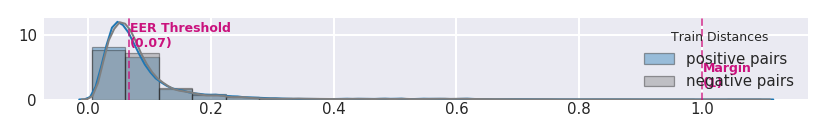


VALID: roc_auc: 0.4979, eer: 0.5068, thres: 0.0688 => acc: 0.4930, f1: 0.4929



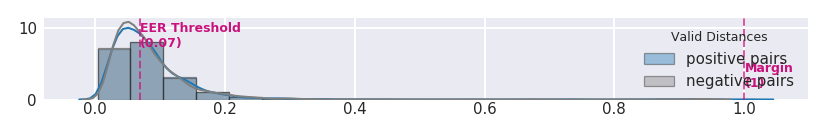

================================[   Epoch 0   ]================================
TRAIN: roc_auc: 0.5952, eer: 0.4413, thres: 0.4360 => acc: 0.5587, f1: 0.5587
val_loss: 0.245, loss: 0.263


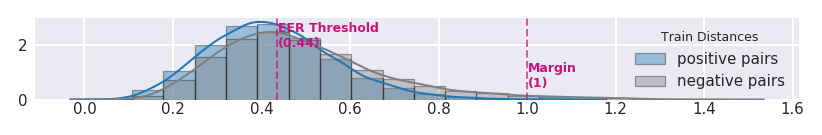


VALID: roc_auc: 0.6080, eer: 0.4294, thres: 0.4481 => acc: 0.5704, f1: 0.5703
val_loss: 0.245, loss: 0.263


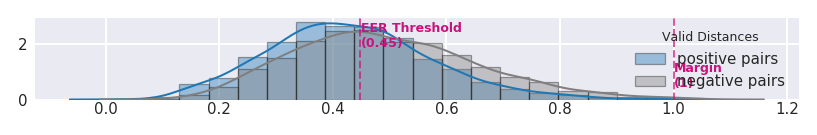

================================[   Epoch 1   ]================================
val_loss: 0.218, loss: 0.239
================================[   Epoch 2   ]================================
val_loss: 0.219, loss: 0.232
================================[   Epoch 3   ]================================
val_loss: 0.199, loss: 0.227
================================[   Epoch 4   ]================================
val_loss: 0.207, loss: 0.224
================================[   Epoch 5   ]================================
TRAIN: roc_auc: 0.7039, eer: 0.3594, thres: 0.4517 => acc: 0.6406, f1: 0.6405
val_loss: 0.190, loss: 0.220


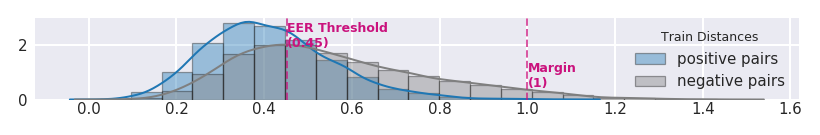


VALID: roc_auc: 0.7781, eer: 0.2958, thres: 0.4833 => acc: 0.7042, f1: 0.7042
val_loss: 0.190, loss: 0.220


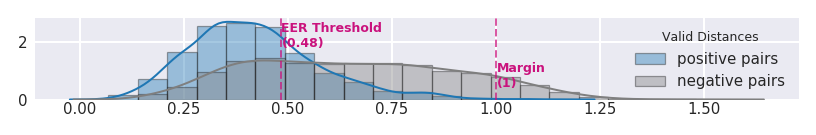

================================[   Epoch 6   ]================================
val_loss: 0.190, loss: 0.216
================================[   Epoch 7   ]================================
val_loss: 0.187, loss: 0.213
================================[   Epoch 8   ]================================
val_loss: 0.190, loss: 0.211
================================[   Epoch 9   ]================================
val_loss: 0.181, loss: 0.208
================================[   Epoch 10   ]================================
TRAIN: roc_auc: 0.7452, eer: 0.3261, thres: 0.4845 => acc: 0.6739, f1: 0.6739
val_loss: 0.188, loss: 0.207


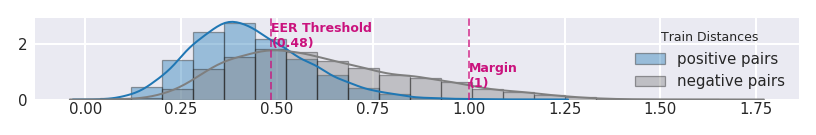


VALID: roc_auc: 0.7901, eer: 0.2865, thres: 0.5226 => acc: 0.7135, f1: 0.7135
val_loss: 0.188, loss: 0.207


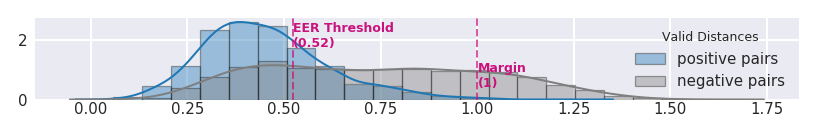

================================[   Epoch 11   ]================================
val_loss: 0.180, loss: 0.205
================================[   Epoch 12   ]================================
val_loss: 0.181, loss: 0.204
================================[   Epoch 13   ]================================
val_loss: 0.181, loss: 0.202
================================[   Epoch 14   ]================================
val_loss: 0.186, loss: 0.201
================================[   Epoch 15   ]================================
TRAIN: roc_auc: 0.7638, eer: 0.3128, thres: 0.4859 => acc: 0.6872, f1: 0.6872
val_loss: 0.185, loss: 0.199


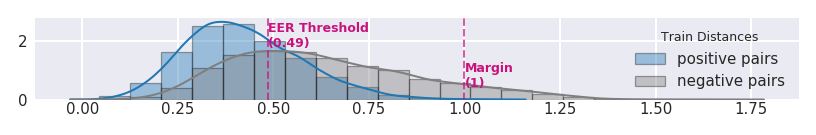


VALID: roc_auc: 0.7963, eer: 0.2849, thres: 0.5265 => acc: 0.7149, f1: 0.7149
val_loss: 0.185, loss: 0.199


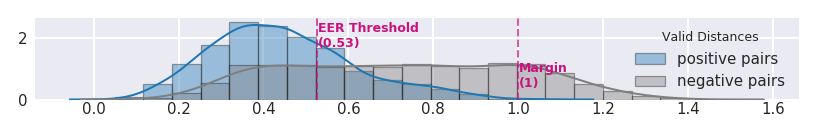

================================[   Epoch 16   ]================================
val_loss: 0.191, loss: 0.199
================================[   Epoch 17   ]================================
val_loss: 0.185, loss: 0.198
================================[   Epoch 18   ]================================
val_loss: 0.182, loss: 0.196
================================[   Epoch 19   ]================================
val_loss: 0.181, loss: 0.196
================================[   Epoch 20   ]================================
TRAIN: roc_auc: 0.7813, eer: 0.2980, thres: 0.4903 => acc: 0.7020, f1: 0.7020
val_loss: 0.181, loss: 0.194


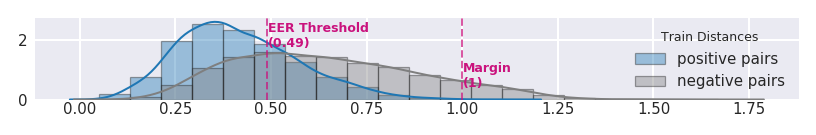


VALID: roc_auc: 0.8046, eer: 0.2787, thres: 0.5227 => acc: 0.7212, f1: 0.7211
val_loss: 0.181, loss: 0.194


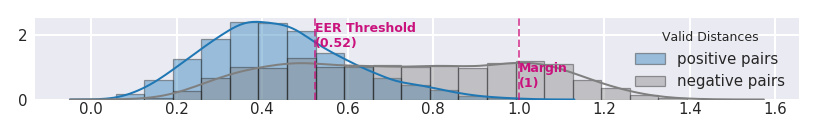

================================[   Epoch 21   ]================================
val_loss: 0.179, loss: 0.194
================================[   Epoch 22   ]================================
val_loss: 0.187, loss: 0.192
================================[   Epoch 23   ]================================
val_loss: 0.186, loss: 0.192
================================[   Epoch 24   ]================================
val_loss: 0.183, loss: 0.190
================================[   Epoch 25   ]================================
TRAIN: roc_auc: 0.7882, eer: 0.2918, thres: 0.4982 => acc: 0.7082, f1: 0.7082
val_loss: 0.182, loss: 0.191


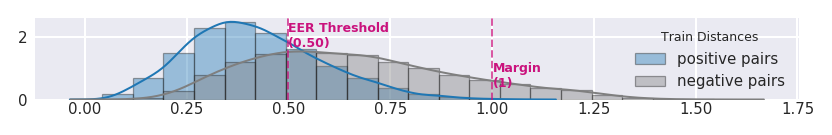


VALID: roc_auc: 0.8083, eer: 0.2736, thres: 0.5345 => acc: 0.7265, f1: 0.7265
val_loss: 0.182, loss: 0.191


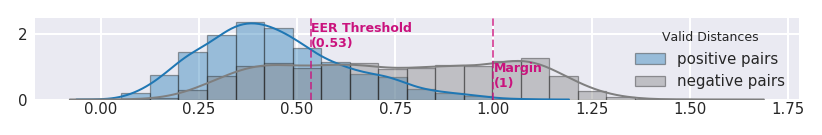

================================[   Epoch 26   ]================================
val_loss: 0.181, loss: 0.190
================================[   Epoch 27   ]================================
val_loss: 0.187, loss: 0.189
================================[   Epoch 28   ]================================
val_loss: 0.186, loss: 0.187
================================[   Epoch 29   ]================================
val_loss: 0.184, loss: 0.188
================================[   Epoch 30   ]================================
TRAIN: roc_auc: 0.7931, eer: 0.2862, thres: 0.4983 => acc: 0.7138, f1: 0.7137
val_loss: 0.182, loss: 0.188


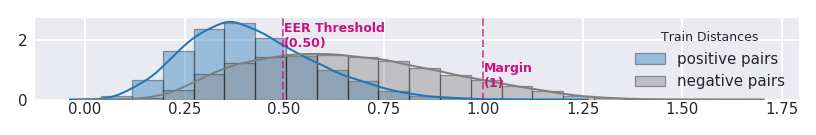


VALID: roc_auc: 0.8061, eer: 0.2758, thres: 0.5305 => acc: 0.7244, f1: 0.7243
val_loss: 0.182, loss: 0.188


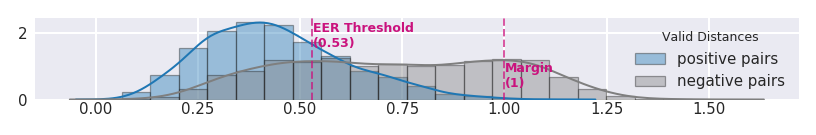

================================[   Epoch 31   ]================================
val_loss: 0.178, loss: 0.187
================================[   Epoch 32   ]================================
val_loss: 0.177, loss: 0.185
================================[   Epoch 33   ]================================
val_loss: 0.185, loss: 0.185
================================[   Epoch 34   ]================================
val_loss: 0.176, loss: 0.185
================================[   Epoch 35   ]================================
TRAIN: roc_auc: 0.8110, eer: 0.2726, thres: 0.4921 => acc: 0.7274, f1: 0.7274
val_loss: 0.178, loss: 0.183


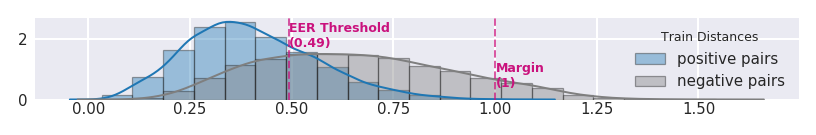


VALID: roc_auc: 0.8142, eer: 0.2718, thres: 0.5224 => acc: 0.7283, f1: 0.7283
val_loss: 0.178, loss: 0.183


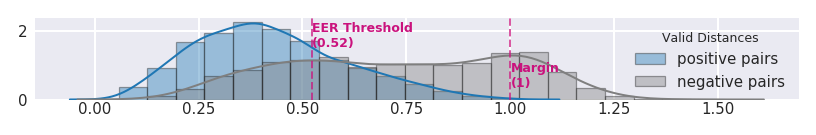

================================[   Epoch 36   ]================================
val_loss: 0.176, loss: 0.183
================================[   Epoch 37   ]================================
val_loss: 0.176, loss: 0.182
================================[   Epoch 38   ]================================
val_loss: 0.180, loss: 0.182
================================[   Epoch 39   ]================================
val_loss: 0.177, loss: 0.181
================================[   Epoch 40   ]================================
TRAIN: roc_auc: 0.8146, eer: 0.2726, thres: 0.4951 => acc: 0.7274, f1: 0.7274
val_loss: 0.176, loss: 0.181


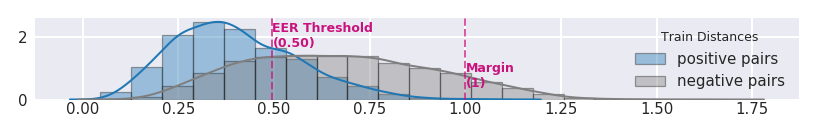


VALID: roc_auc: 0.8169, eer: 0.2658, thres: 0.5193 => acc: 0.7341, f1: 0.7340
val_loss: 0.176, loss: 0.181


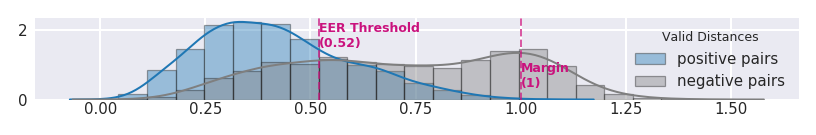

================================[   Epoch 41   ]================================
val_loss: 0.179, loss: 0.180
================================[   Epoch 42   ]================================
val_loss: 0.176, loss: 0.181
================================[   Epoch 43   ]================================
val_loss: 0.182, loss: 0.180
================================[   Epoch 44   ]================================
val_loss: 0.180, loss: 0.179
================================[   Epoch 45   ]================================
TRAIN: roc_auc: 0.8182, eer: 0.2640, thres: 0.5038 => acc: 0.7360, f1: 0.7360
val_loss: 0.178, loss: 0.178


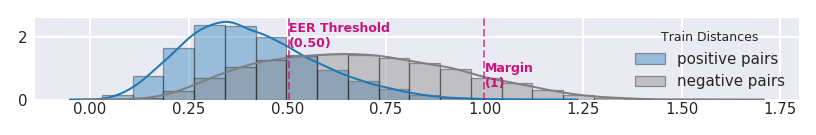


VALID: roc_auc: 0.8139, eer: 0.2747, thres: 0.5282 => acc: 0.7255, f1: 0.7254
val_loss: 0.178, loss: 0.178


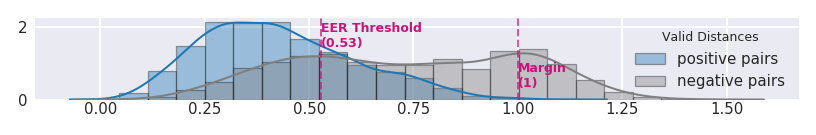

================================[   Epoch 46   ]================================
val_loss: 0.176, loss: 0.178
================================[   Epoch 47   ]================================
val_loss: 0.176, loss: 0.177
================================[   Epoch 48   ]================================
val_loss: 0.179, loss: 0.177
================================[   Epoch 49   ]================================
val_loss: 0.178, loss: 0.176
================================[   Epoch 50   ]================================
TRAIN: roc_auc: 0.8212, eer: 0.2633, thres: 0.5233 => acc: 0.7367, f1: 0.7367
val_loss: 0.182, loss: 0.176


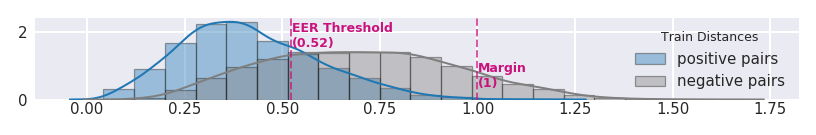


VALID: roc_auc: 0.8103, eer: 0.2776, thres: 0.5360 => acc: 0.7226, f1: 0.7226
val_loss: 0.182, loss: 0.176


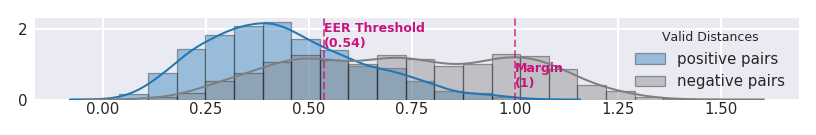

================================[   Epoch 51   ]================================
val_loss: 0.179, loss: 0.176
================================[   Epoch 52   ]================================
val_loss: 0.178, loss: 0.176
================================[   Epoch 53   ]================================
val_loss: 0.176, loss: 0.175
================================[   Epoch 54   ]================================
val_loss: 0.177, loss: 0.174
================================[   Epoch 55   ]================================
TRAIN: roc_auc: 0.8348, eer: 0.2504, thres: 0.4925 => acc: 0.7495, f1: 0.7495
val_loss: 0.175, loss: 0.174


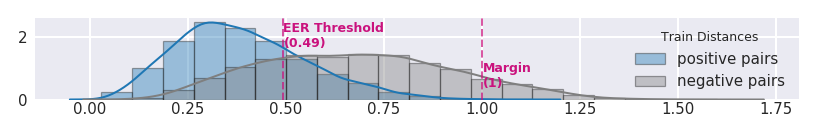


VALID: roc_auc: 0.8161, eer: 0.2711, thres: 0.5146 => acc: 0.7287, f1: 0.7286
val_loss: 0.175, loss: 0.174


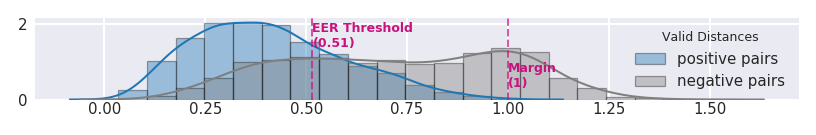

================================[   Epoch 56   ]================================
val_loss: 0.176, loss: 0.174
================================[   Epoch 57   ]================================
val_loss: 0.173, loss: 0.173
================================[   Epoch 58   ]================================
val_loss: 0.176, loss: 0.172
================================[   Epoch 59   ]================================
val_loss: 0.173, loss: 0.173
================================[   Epoch 60   ]================================
TRAIN: roc_auc: 0.8367, eer: 0.2473, thres: 0.5070 => acc: 0.7527, f1: 0.7527
val_loss: 0.178, loss: 0.172


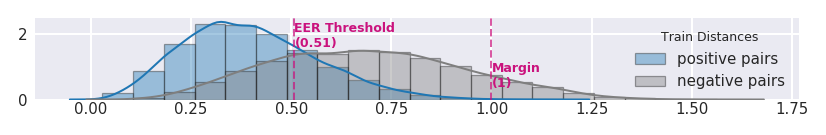


VALID: roc_auc: 0.8120, eer: 0.2779, thres: 0.5265 => acc: 0.7222, f1: 0.7222
val_loss: 0.178, loss: 0.172


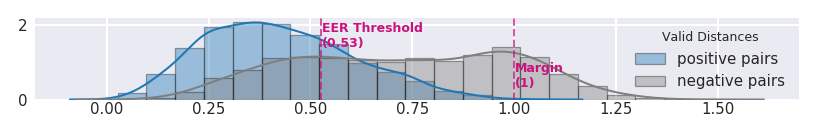

================================[   Epoch 61   ]================================
val_loss: 0.177, loss: 0.173
================================[   Epoch 62   ]================================
val_loss: 0.179, loss: 0.171
================================[   Epoch 63   ]================================
val_loss: 0.176, loss: 0.171
================================[   Epoch 64   ]================================
val_loss: 0.172, loss: 0.171


KeyboardInterrupt: 

In [41]:
# Select model architecture
model, basemodel = get_model(P.model_variant, P.window_size, P.feature_cols, P.filters)

# Select Optimizer
optimizer = get_optimizer(P.optimizer, P.optimizer_lr)

# Compile
warnings.filterwarnings("ignore")
model.compile(loss=k_contrastive_loss, optimizer=optimizer)

# Train
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=P.batch_size,
    epochs=P.epochs_max,
    verbose=0,
    validation_data=(X_valid, y_valid),
    callbacks=[MetricsCallback((X_valid, y_valid, X_train, y_train), epoch_evaluate_freq=5, save_plots=True)],
)

print("Training History:")
plt = utils_plot_training_loss(history)
utils_save_plot(
    plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-epoch-trainloss.pdf"
)
plt.show()

### 4.5 Check Distances <a id='4.5'>&nbsp;</a> 

### 4.6 Rebuild and train to optimal Epoch  <a id='4.6'>&nbsp;</a> 
Now, that we know the learning curve, we can rebuild the model and train it until the best Epoch.

Also, we will include the validation data to have more training data. 

**Note:** This also means, that the training metrics are not valid anymore, because we don't have any validation data left to test against...

### 4.7 Cache model <a id='4.7'>&nbsp;</a> 

## 5. Visualize Deep Features <a id='5'>&nbsp;</a> 

### 5.1 Load cached Data <a id='5.1'>&nbsp;</a> 

In [ ]:
df_siamese_valid = pd.read_msgpack(OUTPUT_PATH / "df_siamese_valid.msg")
df_siamese_train = pd.read_msgpack(OUTPUT_PATH / "df_siamese_train.msg")

df_ocsvm_train_valid = pd.read_msgpack(OUTPUT_PATH / "df_ocsvm_train_valid.msg")

### 5.2 Extract CNN from Siamese Model <a id='5.2'>&nbsp;</a> 
I do this by redirecting inputs and outputs.

However, the network still needs a pair as input (I wasn't able to change this). This slows down a little bit the prediction (as the input is predicted twice), but doesn't change the results.

In [ ]:
def load_deep_feature_model(model_path):
    # Copy of function from above. It's just more convenient for partially 
    # executing the notebook.
    def k_contrastive_loss(y_true, dist):
        """Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        """
        margin = P.margin
        return K.mean(
            y_true * K.square(dist)
            + (1 - y_true) * K.square(K.maximum(margin - dist, 0))
        )
    
    # Load Trained Siamese Network
    model = load_model(
        str(model_path.resolve()),
        custom_objects={"k_contrastive_loss": k_contrastive_loss},
    )

    # Extract one of the child networks
    deep_feature_model = Model(
        inputs=model.get_input_at(0),  # get_layer("left_inputs").input,
        outputs=model.get_layer("basemodel").get_output_at(1),
    )
    
    return deep_feature_model

In [ ]:
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")
deep_feature_model.summary()

### 5.3 Test Generation of Deep Features <a id='5.3'>&nbsp;</a> 

In [ ]:
def prep_X_y_single(df):
    X = np.stack(list(df["X"].values))
    y = df["label"].values
    return X, y

In [ ]:
def transform_to_sample_by_subject(df):
    sample_by_subject = []
    df["label"] = 1
    for subj in df["subject"].unique():
        df_subj = df[df["subject"] == subj]
        X_sub, y_sub = prep_X_y_single(df_subj)
        sample_by_subject.append((X_sub, y_sub, subj))
    return sample_by_subject

#### Select subset (for plotting) and transform features

In [ ]:
# Concat Valid & Train (both were used for last Training)
df_train_temp = pd.concat([df_siamese_valid, df_siamese_train])
df_test_temp = df_ocsvm_train_valid

# Select data from 20 subjects of the TRAINING SET
random.seed(SEED)
ten_subjects = random.sample(df_train_temp["subject"].unique().tolist(), 20)
df_train_temp = df_train_temp[df_train_temp["subject"].isin(ten_subjects)].copy()
df_train_temp = df_train_temp.groupby("subject").apply(lambda x: x.sample(n=300, random_state=SEED))  # Plot only subset of samples

# Select data from 10 subjects of the TEST SET (not included in training)
random.seed(SEED)
ten_subjects = random.sample(df_test_temp["subject"].unique().tolist(), 10)
df_test_temp = df_test_temp[df_ocsvm_train_valid["subject"].isin(ten_subjects)].copy()
df_test_temp = df_test_temp.groupby("subject").apply(lambda x: x.sample(n=300, random_state=SEED))  # Plot only subset of samples

# Transform Samples
samples_train = transform_to_sample_by_subject(df_train_temp)
samples_test = transform_to_sample_by_subject(df_test_temp)

print(f"First subject: {samples_train[0][2]}")
print(f"y shape: {samples_train[0][1].shape}")
print(f"X shape: {samples_train[0][0].shape}")

#### Predict Deep Features

In [ ]:
deep_features_train = None
for X, y, subj in samples_train:  
    if P.model_variant == "2d":
        X = X.reshape((*X.shape, 1))
    pred = deep_feature_model.predict([X, X])
    df_features = pd.DataFrame(pred)
    df_features["subject"] = subj
    deep_features_train = pd.concat([deep_features_train, df_features])
        
deep_features_test = None
for X, y, subj in samples_test:  
    if P.model_variant == "2d":
        X = X.reshape((*X.shape, 1))
    pred = deep_feature_model.predict([X, X])
    df_features = pd.DataFrame(pred)
    df_features["subject"] = subj
    deep_features_test = pd.concat([deep_features_test, df_features])
        
display(deep_features_train.head(3))
display(deep_features_test.head(3))

### 5.4 Visualize in 2D using PCA <a id='5.4'>&nbsp;</a> 

In [ ]:
def plot_pca(df):
    # PCA
    pca = PCA(n_components=2)
    deep_transformed = pca.fit_transform(df.drop(columns=["subject"]).values)

    # Create df with data needed for chart only
    df_viz = df.copy()
    df_viz["PCA0"] = deep_transformed[:, 0]
    df_viz["PCA1"] = deep_transformed[:, 1]
    df_viz.drop(
        columns=[c for c in df_viz.columns if c not in ["PCA0", "PCA1", "subject"]]
    )

    # Generate color index for every subject
    df_viz["Subject"] = pd.Categorical(df_viz["subject"])
    df_viz["colors"] = df_viz["Subject"].cat.codes

    if len(df_viz["Subject"].unique()) <= 10:
        pal = sns.color_palette("tab10")
    else:
        pal = sns.color_palette("tab20")
        
    # Actual plot
    fig = plt.figure(figsize=(5.473 / 1.5, 5.473 / 2), dpi=180)
    sns.scatterplot(
        x="PCA0",
        y="PCA1",
        data=df_viz,
        hue="Subject",
        legend="full",
        palette=pal,
        s=2,
        linewidth=0,
        alpha=0.6,
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=5)
    fig.tight_layout()
    return plt

In [ ]:
plot_pca(deep_features_train)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-pca-train.pdf")

In [ ]:
plot_pca(deep_features_test)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-pca-test.pdf")

In [ ]:
### Cleanup memory
%reset_selective -f df_
%reset_selective -f X_
%reset_selective -f y_
%reset_selective -f pca

## 6. OCSVM <a id='6'>&nbsp;</a> 

### 6.1 Load cached Data <a id='6.1'>&nbsp;</a> 

In [43]:
df_ocsvm_train_valid = pd.read_msgpack(OUTPUT_PATH / "df_ocsvm_train_valid.msg")
df_ocsvm_train_valid.head()

,X,subject,session,task_type
0,"((-8.607810569636623, 0.9955167241816556, -1.9...",186676,186676_session_1,4
1,"((-0.3209477333333335, 3.128859958333334, 9.44...",186676,186676_session_1,4
2,"((-2.057314, 4.621461133928572, 7.006203626785...",186676,186676_session_1,4
3,"((0.534176783756579, 6.0081232518346415, 8.295...",186676,186676_session_1,4
4,"((-1.53348510239776, 5.71207867121504, 8.14309...",186676,186676_session_1,4


### 6.2 Load trained Siamese Model <a id='6.2'>&nbsp;</a> 

**Helper methods to load model:**

In [44]:
def load_deep_feature_model(model_path):
    warnings.filterwarnings("ignore")  # Silence depr. warnings

    # Copy of function from above. It's just more convenient for partially executing the notebook.
    def k_contrastive_loss(y_true, dist):
        """Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        """
        margin = P.margin
        return K.mean(
            y_true * K.square(dist)
            + (1 - y_true) * K.square(K.maximum(margin - dist, 0))
        )

    # Load Trained Siamese Network
    model = load_model(
        str(model_path.resolve()),
        custom_objects={"k_contrastive_loss": k_contrastive_loss},
    )

    # Extract one of the child networks
    deep_feature_model = Model(
        inputs=model.get_input_at(0),  # get_layer("left_inputs").input,
        outputs=model.get_layer("basemodel").get_output_at(1),
    )

    return deep_feature_model

**Sanity Check:**

### 6.3 Search for Parameters <a id='6.3'>&nbsp;</a> 

In [ ]:
df_ocsvm_train_valid.head()

In [ ]:
a=[1,16,32][::-1]
print(a)

In [45]:
from pyod.models.vae import VAE
from keras import losses
from keras import activations

param_dist = {
                "l2_regularizer" :  np.linspace(1, 0,5) ,
                "contamination" :   np.linspace(.5, 0,3) ,
                "dropout_rate" :  [.25,0,.5] ,
                "optimizer" : ['adam', 'sgd'], 
    
                "batch_size" :  np.arange(32,64,16),
                "epochs" : np.arange(100,500,100),
                "gamma" : np.linspace(2, 0,5) , 
                "capacity" : np.linspace(1, 0,3) , 
                "loss": [losses.mse, losses.msle, losses.poisson, losses.mape, losses.mae, losses.kld] , 
                "output_activation": [ activations.relu, activations.sigmoid, activations.softmax, activations.softplus,
                                      activations.softsign, activations.tanh, activations.selu, activations.elu, activations.exponential],
                "hidden_activation": [ activations.relu, activations.sigmoid, activations.softmax, activations.softplus,
                                      activations.softsign, activations.tanh, activations.selu, activations.elu, activations.exponential]

                 }

# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")



encoder_architectures = [
    [32,24,16,8,4,2,1],
    [32,16,8,4,2,1],
    [32,16,8,4,1],
    [32,16,8,4,2],
    [32,16,8,4],
    [32,16,8,2],
    #[32,16,2],
    #[32,4],
    #[32,2]
]
all_df_reports=[] 
for enc in encoder_architectures[::-1]: 
    df_results = None  # Will be filled with randomsearch scores
    for run in tqdm(range(3)):
        for df_cv_scenarios, owner, impostors in tqdm(
            utils_generate_cv_scenarios(
                df_ocsvm_train_valid,
                samples_per_subject_train=P.samples_per_subject_train,
                samples_per_subject_test=P.samples_per_subject_test,
                seed=SEED + run,
                scaler=P.scaler,
                scaler_global=P.scaler_global,
                scaler_scope=P.scaler_scope,
                deep_model=deep_feature_model,
                model_variant=P.model_variant,
                feature_cols=P.feature_cols,
            ),
            desc="Owner",
            total=df_ocsvm_train_valid["subject"].nunique(),
            leave=False,
        ):

            X = np.array(df_cv_scenarios["X"].values.tolist())
            y = df_cv_scenarios["label"].values

            train_valid_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

            dec=enc[::-1]

            print(      enc,dec)
            model = VAE(enc,dec)

            warnings.filterwarnings("ignore")
            random_search = RandomizedSearchCV(
                model,
                param_distributions=param_dist,
                cv=train_valid_cv,
                n_iter=80,
                n_jobs=CORES,
                refit=False,
                scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
                verbose=0,
                return_train_score=False,
                iid=False,
                error_score=np.nan,
                random_state=SEED,
            )

            random_search.fit(X, y)

            df_report = utils_cv_report(random_search, owner, impostors)
            df_report["run"] = run
            df_results = pd.concat([df_results, df_report], sort=False)
        all_df_reports.append([enc,df_results])
        df_results.to_csv(OUTPUT_PATH / f"{P.name+str(enc)}__VAE__random_search_results_again.csv", index=False)

/gpfs/fs1/home/u/uhengart/ezzeldi/contauth/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


[32, 16, 8, 2] [2, 8, 16, 32]


[32, 16, 8, 2] [2, 8, 16, 32]


[32, 16, 8, 2] [2, 8, 16, 32]


[32, 16, 8, 2] [2, 8, 16, 32]


[32, 16, 8, 2] [2, 8, 16, 32]


[32, 16, 8, 2] [2, 8, 16, 32]


[32, 16, 8, 2] [2, 8, 16, 32]


[32, 16, 8, 2] [2, 8, 16, 32]


[32, 16, 8, 2] [2, 8, 16, 32]


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

### 6.4 Inspect Search Results <a id='6.4'>&nbsp;</a> 
**Raw Results & Stats:**

In [ ]:
for enc in encoder_architectures[::-1]: 
    df_results = pd.read_csv(OUTPUT_PATH / f"{P.name+str(enc)}__VAE__random_search_results.csv")
    print("Best results for each owner:")

    display(
        df_results[df_results["rank_test_eer"] <= 1][
            [
                "owner",
                "rank_test_eer",
                "mean_test_eer",
                "std_test_eer",
                "mean_test_accuracy",
                "std_test_accuracy",
            ]
        ].sort_values("mean_test_eer").head(10)
    )

    print("\n\n\nMost relevant statistics:")
    display(
        df_results[df_results["rank_test_eer"] <= 1][
            [
                "mean_fit_time",
                "mean_test_accuracy",
                "std_test_accuracy",
                "mean_test_eer",
                "std_test_eer",
            ]
        ].describe()
    )

**Plot parameters of top n of 30 results for every Owner:**

In [ ]:
utils_plot_randomsearch_results(df_results, 1)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-parameters.pdf")

## 7. Testing <a id='7'>&nbsp;</a> 

### 7.1 Load cached Data <a id='7.1'>&nbsp;</a> 
During testing, a split with different users than used for hyperparameter optimization is used:

In [ ]:
df_ocsvm_train_test = pd.read_msgpack(OUTPUT_PATH / "df_ocsvm_train_test.msg")

### 7.2 Evaluate Authentication Performance <a id='7.2'>&nbsp;</a> 
- Using Testing Split, Scenario Cross Validation, and multiple runs to lower impact of random session/sample selection.

In [ ]:
# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(5), desc="Run", leave=False):  # Run whole test 5 times
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_test,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_test["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = VAE([32,16,8,1],[1,8,16,32], 
                contamination=.5, optimizer='sgd',                
                gamma=3 , 
                capacity=.5 , 
                loss=losses.kld,
                batch_size=32, 
                dropout_rate=.25,
                epochs=200,
                output_activation=activations.selu, 
                hidden_activation=activations.sigmoid, 
    )

        warnings.filterwarnings("ignore")
        scores = cross_validate(
            model,
            X,
            y,
            cv=train_test_cv,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            n_jobs=CORES,
            verbose=1,
            return_train_score=True,
        )
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_VAE_test_results.csv", index=False)
df_results.head()

**Load Results from "EER & Accuracy" evaluation & prepare for plotting:**

In [ ]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_VAE_test_results.csv")
df_plot = df_results.rename(
    columns={"test_accuracy": "Test Accuracy", "test_eer": "Test EER", "owner": "Owner"}
).astype({"Owner": str})

**Plot Distribution of Accuracy per subject:**

In [ ]:
fig = utils_plot_acc_eer_dist(df_plot, "mean_test_accuracy")
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-acc.pdf")

**Plot Distribution of EER per subject:**

In [ ]:
fig = utils_plot_acc_eer_dist(df_plot, "mean_test_eer") # with new archi [32,16,4,1],[1,4,16,32] instead of [32,16,8,4,1],[1,4,8,16,32]
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-eer.pdf")

In [ ]:
fig = utils_plot_acc_eer_dist(df_plot, "mean_test_eer")
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-eer.pdf")

### 7.3 Evaluate increasing Training Set Size (Training Delay) <a id='7.3'>&nbsp;</a> 

In [ ]:
training_set_sizes = [1, 2, 3, 4, 10, 30, 60, 90, 125, 175, 250, 375]  # In samples

deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(5), desc="Run", leave=False):  # Run whole test 5 times
    for n_train_samples in tqdm(training_set_sizes, desc="Train Size", leave=False):
        for df_cv_scenarios, owner, impostors in tqdm(
            utils_generate_cv_scenarios(
                df_ocsvm_train_test,
                samples_per_subject_train=P.samples_per_subject_train,
                samples_per_subject_test=P.samples_per_subject_test,
                limit_train_samples=n_train_samples,  # samples overall
                seed=SEED + i,
                scaler=P.scaler,
                scaler_global=P.scaler_global,
                scaler_scope=P.scaler_scope,
                deep_model=deep_feature_model,
                model_variant=P.model_variant,
                feature_cols=P.feature_cols,
            ),
            desc="Owner",
            total=df_ocsvm_train_test["subject"].nunique(),
            leave=False,
        ):
            X = np.array(df_cv_scenarios["X"].values.tolist())
            y = df_cv_scenarios["label"].values

            train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

            model = VAE([32,16,8,4,1],[1,4,8,16,32], contamination=.5, optimizer='sgd',                
                gamma=3 , 
                capacity=.5 , 
                loss=losses.kld,
                batch_size=32, 
                dropout_rate=.25,
                epochs=200,
                output_activation=activations.selu, 
                hidden_activation=activations.sigmoid, 
    )

            warnings.filterwarnings("ignore")
            scores = cross_validate(
                model,
                X,
                y,
                cv=train_test_cv,
                scoring={"eer": utils_eer_scorer},
                n_jobs=CORES,
                verbose=0,
                return_train_score=True,
            )
            df_score = pd.DataFrame(scores)
            df_score["owner"] = owner
            df_score["train_samples"] = n_train_samples
            df_score["train_eer"] = df_score[
                "train_eer"
            ].abs()  # Revert scorer's signflip
            df_score["test_eer"] = df_score["test_eer"].abs()
            df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_train_delay_results.csv", index=False)
df_results.head()

**Load Results from "Training set size" evaluation & prepare for plotting:**

In [ ]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_train_delay_results.csv")
df_plot = (
    df_results[["test_eer", "owner", "train_samples"]]
    .groupby(["owner", "train_samples"], as_index=False)
    .mean()
    .astype({"owner": "category"})
    .rename(
        columns={
            "test_eer": "Test EER",
            "owner": "Owner",
        }
    )
)
df_plot["Training Data in Seconds"] = df_plot["train_samples"] * P.window_size / P.frequency

**Plot EER with increasing number of training samples:**

In [ ]:
utils_plot_training_delay(df_plot)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-train-size.pdf")

### 7.4 Evaluate increasing Test Set Sizes (Detection Delay)<a id='7.4'>&nbsp;</a> 

In [ ]:
# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(50), desc="Run", leave=False):  # Run whole test 5 times
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_test,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            limit_test_samples=1,  # Samples overall
            seed=SEED + i,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_test["subject"].nunique(),
        leave=False,
    ):
        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = VAE([32,16,8,4,1],[1,4,8,16,32], contamination=.5, optimizer='sgd',                
                gamma=3 , 
                capacity=.5 , 
                loss=losses.kld,
                batch_size=32, 
                dropout_rate=.25,
                epochs=200,
                output_activation=activations.selu, 
                hidden_activation=activations.sigmoid, 
    )

        warnings.filterwarnings("ignore")
        scores = cross_validate(
            model,
            X,
            y,
            cv=train_test_cv,
            scoring={"eer": utils_eer_scorer},
            n_jobs=CORES,
            verbose=0,
            return_train_score=True,
        )
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner
        df_score["run"] = i
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_detect_delay_results.csv", index=False)
df_results.head()

**Load Results from "Detection Delay" evaluation & prepare for plotting:**

In [ ]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_detect_delay_results.csv")
df_results["owner"] = df_results["owner"].astype(str)
df_plot = df_results.copy()

**Plot Expanding Mean EER and confidence interval:**

In [ ]:
utils_plot_detect_delay(df_plot, factor=P.window_size / P.frequency, xlim=160)
utils_save_plot(
    plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-detection-delay.pdf"
)